# Introduction
State notebook purpose here

### Imports
Import libraries and write settings here.

In [1]:
# Notebooks specific imports
from IPython import get_ipython
ipython = get_ipython()
#Expand notebook display

from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload
%autoreload 2
from tqdm.notebook import tqdm

# Basic useful imports
import re
import time
import yaml
from pprint import pprint
from pathlib import Path
import h5py
import warnings
import sys
sys.setrecursionlimit(10000)

# Data manipulation
import numpy as np
from scipy.special import erf
from scipy.integrate import quad, solve_ivp
import scipy.stats as stats
from scipy.signal import savgol_filter
from scipy.spatial import ConvexHull

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
from matplotlib.patches import (Circle, RegularPolygon, FancyArrowPatch, ArrowStyle)
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, NullFormatter)
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
from dyn_cond_fig_functions import *

# Clustering stuff
from sklearn.cluster import MeanShift, estimate_bandwidth, DBSCAN, OPTICS
from itertools import cycle
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# plt.cm.tab20.colors

# From alens_analysis.py
import alens_analysis as aa
import alens_analysis.chromatin as aac
import alens_analysis.chromatin.chrom_analysis as ca
import alens_analysis.chromatin.chrom_condensate_analysis as cca
import alens_analysis.chromatin.chrom_graph_funcs as cgf
from alens_analysis import cluster_analysis as cla

from alens_analysis.colormaps import register_cmaps

# Locations
ws_path = Path('/home/alamson/DATA/Chromatin/')
mnt_path = Path.home() / 'projects/DATA/Chromatin/'
ceph_path = Path.home() / 'ceph/DATA/Chromatin/'

cuda


### Style settings

In [2]:
graph_sty = {
    "axes.titlesize": 20,
    "axes.labelsize": 24,
    "lines.linewidth": 2,
    "lines.markersize": 2,
    "xtick.labelsize": 24,
    "ytick.labelsize": 24,
    "font.size": 20,
    "font.sans-serif": 'DejaVu Sans',
    "text.usetex": False,
    'mathtext.fontset': 'cm',
}
plt.style.use(graph_sty)

colors = cycle(mcolors.XKCD_COLORS.keys())

plt.rcParams['image.cmap'] = 'YlOrRd'
        

In [3]:
cluster_similarity_threshold = .4 
nskip = 10 # Time snapshot skips for cluster finding. = 10 secs
vmax = 40 # Max colorbar value in kymographs
tree_length = 30 # min length of a cluster tree in time snapshots. = 15 sec

# Figure 7

## Snapshots of the simulation

In [4]:
!pvpython /mnt/home/alamson/ceph/DATA/Chromatin/DynCondPaper/pv_snapshot_chromatin.py /mnt/home/alamson/ceph/DATA/Chromatin/DynCondPaper/equilibration/24-04-12_aLc1_scan.48_line1600_Pin5um_2xKe30_2patch_sep100/simulations/s1/

!cp /mnt/home/alamson/ceph/DATA/Chromatin/DynCondPaper/equilibration/24-04-12_aLc1_scan.48_line1600_Pin5um_2xKe30_2patch_sep100/simulations/s1/snapshot_chromatin_last.png Figure7/two_patch_snapshot.png

Final snapshot of the baseline simulation at 3um separation and Ke=100.

<img width="50%" src="Figure6/two_patch_snapshot.png?raw=true"></img>


In [ ]:
# Takes about 3 minutes

fig, axarr = plt.subplots(2,3, figsize=(21, 12), sharex=True, sharey='row')
plot_params = {"linewidth": 1, "markersize": .5, "marker":'', "alpha":0.3, "linestyle":'-'}

_ = axarr[0,0].set_ylim(0, 1600)
large_tree_length = 100

## Upper row

# Merge event
h5_contact_file = ceph_path / "DynCondPaper/24-04-15_aLc1_scan.48_line1600_Pin5um_2xKe30_ks100_2patch_sep100_equil/simulations/s27/analysis/cluster_analysis.h5"
with h5py.File(h5_contact_file, 'r') as h5_data:
    cluster_grp = h5_data['clusters']
    time_arr = h5_data['time'][...]
    time_grp_list = sorted(cluster_grp.values(), key=lambda x: x.attrs['time'])
    clusters = []
    for tg in time_grp_list:
        clusters += [[cla.Cluster(h5_data = c) for c in tg.values()]]

    # Cluster tree
    root_clusters = cla.find_descendants(clusters, thresh=cluster_similarity_threshold, nskip=nskip)

    trees = []
    tree_id_gen = aa.helpers.gen_id()
    for root in root_clusters:
        tree = cla.ClusterTree(next(tree_id_gen))
        tree.add_recursive(root)
        trees += [tree]

    # Graph all clusters
    for tree in trees:
        if len(tree.clusters) < large_tree_length:
            continue
        for clust in tree.clusters:
            _ = axarr[0,0].plot([clust.time]*len(clust.part_ids), clust.part_ids, color = 'C1', markersize= .1, marker='.', linestyle='None')
    _ = axarr[0,0].set_title('Merge event', fontsize=26)

# Dissolve event
h5_contact_file = ceph_path / "DynCondPaper/24-04-15_aLc1_scan.48_line1600_Pin5um_2xKe30_ks100_2patch_sep100_equil/simulations/s25/analysis/cluster_analysis.h5"
with h5py.File(h5_contact_file, 'r') as h5_data:
    cluster_grp = h5_data['clusters']
    time_arr = h5_data['time'][...]
    time_grp_list = sorted(cluster_grp.values(), key=lambda x: x.attrs['time'])
    clusters = []
    for tg in time_grp_list:
        clusters += [[cla.Cluster(h5_data = c) for c in tg.values()]]

    # Cluster tree
    root_clusters = cla.find_descendants(clusters, thresh=cluster_similarity_threshold, nskip=nskip)

    trees = []
    tree_id_gen = aa.helpers.gen_id()
    for root in root_clusters:
        tree = cla.ClusterTree(next(tree_id_gen))
        tree.add_recursive(root)
        trees += [tree]

    # Graph all clusters
    for tree in trees:
        if len(tree.clusters) < large_tree_length:
            continue
        for clust in tree.clusters:
            _ = axarr[0,1].plot([clust.time]*len(clust.part_ids), clust.part_ids, color = 'C0', markersize= .1, marker='.', linestyle='None')
    _ = axarr[0,1].set_title('Dissolve event', fontsize=26)

# No event
h5_contact_file = ceph_path / "DynCondPaper/24-04-15_aLc1_scan.48_line1600_Pin5um_2xKe30_ks100_2patch_sep100_equil/simulations/s24/analysis/cluster_analysis.h5"
with h5py.File(h5_contact_file, 'r') as h5_data:
    cluster_grp = h5_data['clusters']
    time_arr = h5_data['time'][...]
    time_grp_list = sorted(cluster_grp.values(), key=lambda x: x.attrs['time'])
    clusters = []
    for tg in time_grp_list:
        clusters += [[cla.Cluster(h5_data = c) for c in tg.values()]]

    # Cluster tree
    root_clusters = cla.find_descendants(clusters, thresh=cluster_similarity_threshold, nskip=nskip)

    trees = []
    tree_id_gen = aa.helpers.gen_id()
    for root in root_clusters:
        tree = cla.ClusterTree(next(tree_id_gen))
        tree.add_recursive(root)
        trees += [tree]

    # Graph all clusters
    for tree in trees:
        if len(tree.clusters) < large_tree_length:
            continue
        for clust in tree.clusters:
            _ = axarr[0,2].plot([clust.time]*len(clust.part_ids), clust.part_ids, color = 'grey', markersize= .1, marker='.', linestyle='None')
    _ = axarr[0,2].set_title('No event', fontsize=26)

_ = axarr[0,0].set_ylabel('Bead index')
_ = axarr[0,0].invert_yaxis()


## Lower row
with h5py.File("Figure7/fig7_cluster_data.h5", 'r') as h5_graph:
    for name, d_set in h5_graph['merge'].items():
        condition = d_set[:,1] > 40 
        _ = axarr[1,0].plot(d_set[condition,0], d_set[condition,1], color='tab:orange', **plot_params)

    for name, d_set in h5_graph['dissolve'].items():
        condition = d_set[:,1] > 40 
        _ = axarr[1,1].plot(d_set[condition,0], d_set[condition,1], color='tab:blue', **plot_params)

    for name, d_set in h5_graph['nothing'].items():
        condition = d_set[:,1] > 40 
        _ = axarr[1,2].plot(d_set[condition,0], d_set[condition,1], color='k', **plot_params)

_ = axarr[1,0].set_ylabel('$\ell_i$ [beads] ' )
for ax in axarr[1]:
    _ = ax.set_xlabel('$t$ [$s$]')


fig.tight_layout()

_ = axarr[0,0].text(0.05, .93, "A", fontsize=26, transform=axarr[0,0].transAxes, fontweight='bold')
_ = axarr[0,1].text(0.05, .93, "B", fontsize=26, transform=axarr[0,1].transAxes, fontweight='bold')
_ = axarr[0,2].text(0.05, .93, "C", fontsize=26, transform=axarr[0,2].transAxes, fontweight='bold')
_ = axarr[1,0].text(0.05, .93, "D", fontsize=26, transform=axarr[1,0].transAxes, fontweight='bold')
_ = axarr[1,1].text(0.05, .93, "E", fontsize=26, transform=axarr[1,1].transAxes, fontweight='bold')
_ = axarr[1,2].text(0.05, .93, "F", fontsize=26, transform=axarr[1,2].transAxes, fontweight='bold')

fig.savefig("Figure7/fig7_merge_dissolve_no_event_kymos.png", dpi=600,bbox_inches='tight')
fig.savefig("/mnt/home/alamson/papers/dyn_cond_paper/images/fig7_merge_dissolve_no_event_kymos.png", dpi=300, bbox_inches="tight")
# Takes about 3 minutes


findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

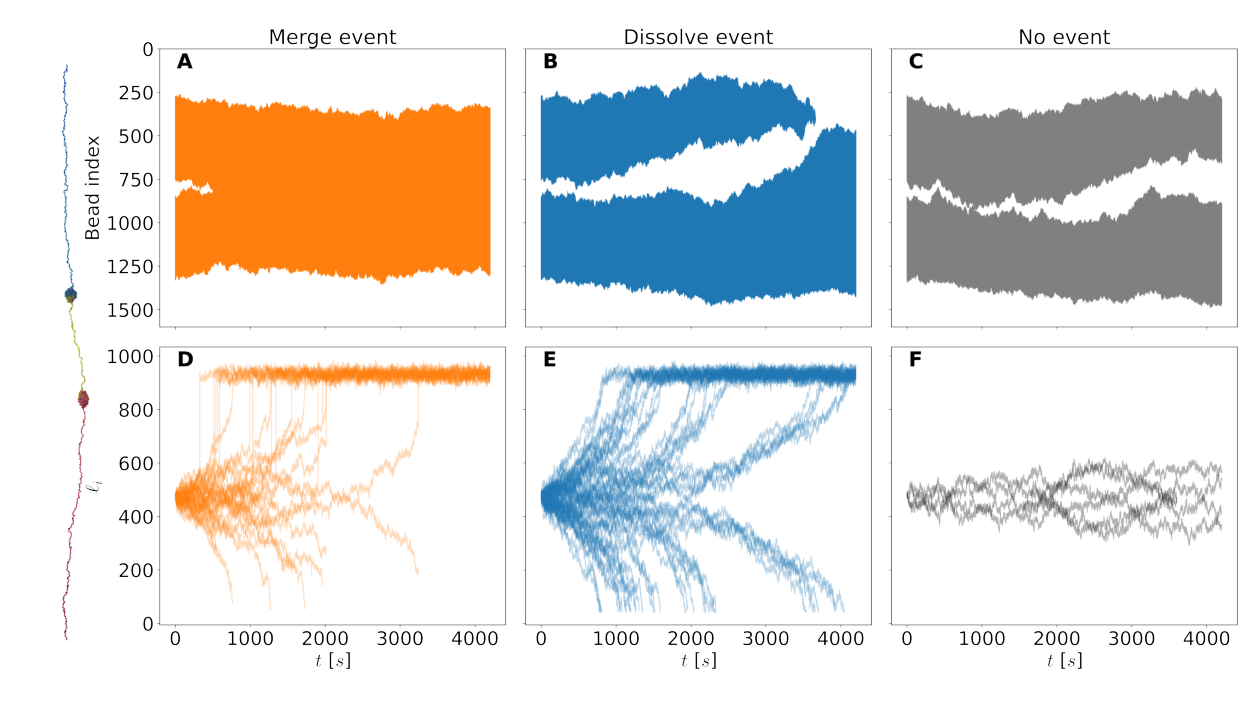

In [9]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.transforms import Affine2D

# Load the image
plot_image_path = "Figure7/fig7_merge_dissolve_no_event_kymos.png"
plot_img = mpimg.imread(plot_image_path)
snap_image_path = 'Figure7/two_patch_snapshot.png'
snap_img = mpimg.imread(snap_image_path)

# Create a figure
fig = plt.figure(figsize=(21, 12))

# Add a main plot
ax_main = fig.add_subplot(111)
_ = ax_main.imshow(plot_img)
_ = ax_main.axis('off')
# ax_main.set_title('Main Plot')

# Add an inset with the image
rotation = Affine2D().rotate_deg(90)  # Rotate 45 degrees
aspect_ratio = snap_img.shape[0] / snap_img.shape[1]
ax_inset = fig.add_axes([.08, 0.1, .1, .8])  # [left, bottom, width, height]
_ = ax_inset.imshow(snap_img, transform=rotation + ax_inset.transData, extent=[-snap_img.shape[0]/2, snap_img.shape[0]/2, -snap_img.shape[1]/2, snap_img.shape[1]/2])
_ = ax_inset.set_xlim(-snap_img.shape[0]*.4, snap_img.shape[0]* .4)
_ = ax_inset.set_ylim(-snap_img.shape[1]*.3, snap_img.shape[1]* .3 )
_ = ax_inset.set_aspect('auto')
_ = ax_inset.axis('off')
_ = ax_main.set_zorder(1)

# ax_inset.axis('off')

fig.savefig("Figure7/fig7_merge_dissolve_no_event_kymos_combined.png", dpi=600,bbox_inches='tight')
fig.savefig("/mnt/home/alamson/papers/dyn_cond_paper/images/fig7_merge_dissolve_no_event_kymos_combined.png", dpi=300, bbox_inches="tight")

# Show the plot
plt.show()

28

17

3

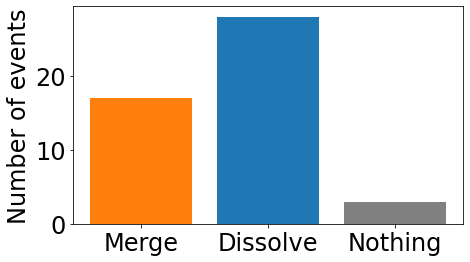

In [15]:
# Bar graph of merge events vs dissolve events vs nothing events
fig, ax = plt.subplots(1,1, figsize=(7, 4))
with h5py.File("Figure7/fig7_cluster_data.h5", 'r') as h5_graph:
    merge_times = h5_graph['merge'].attrs['merge_times']
    dissolve_times = h5_graph['dissolve'].attrs['dissolve_times']
    nothing_events = h5_graph['nothing'].attrs['nothing_events']
    _ = ax.bar(['Merge', 'Dissolve', 'Nothing'], [len(merge_times), len(dissolve_times), nothing_events], color=['tab:orange', 'tab:blue', 'grey'])
    _ = ax.set_ylabel('Number of events')
len(dissolve_times)
len(merge_times)
nothing_events
fig.savefig("Figure7/merge_dissolve_no_event_count.png", dpi=600,bbox_inches='tight')

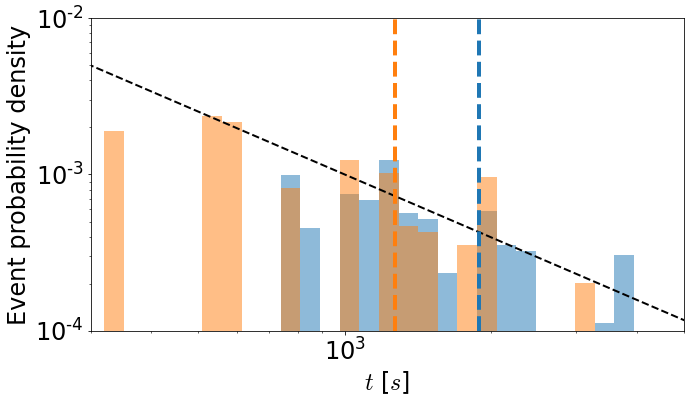

In [16]:
# Histogram of all events
fig, axarr = plt.subplots(1,1, figsize=(10, 6))

# _ = ax.hist(merge_life_times, bins=20, color='tab:orange', alpha=.5, label='Merge', range=(0, 4200))
# _ = ax.hist(dissolve_life_times, bins=20, color='tab:blue', alpha=.5, label='Dissolve',range=(0, 4200))
# _ = ax.set_xlabel('Event times $t_{D/M}$ [$s$]')
# _ = ax.set_ylabel('Number of events')

bins_total = np.logspace(0, 4, 100)

_ = axarr.hist(dissolve_times, bins=bins_total, label='Dissolve', alpha=.5, density=True)
_ = axarr.hist(merge_times, bins=bins_total, label='Merge', alpha=.5, density=True)
_ = axarr.plot(bins_total, 10*np.power(bins_total, -4/3), linestyle='--', color='k', linewidth=2, label=r'$\propto t^{-4/3}$')
_ = axarr.axvline(np.mean(dissolve_times), color='tab:blue', linestyle='--', linewidth=4,
                       label=convert_e_to_x10n(rf'$\langle t_D \rangle = {np.mean(dissolve_times):.3g}\; s$'))
_ = axarr.axvline(np.mean(merge_times), color='tab:orange', linestyle='--', linewidth=4,
                       label=convert_e_to_x10n(rf'$\langle t_M \rangle = {np.mean(merge_times):.3g}\; s$'))
# _ = axarr.legend()
_ = axarr.set_yscale('log')  
_ = axarr.set_xscale('log')  
_ = axarr.set_ylabel('Event probability density')
_ = axarr.set_xlim(300, 5000)
_ = axarr.set_ylim(1e-4, 1e-2)

_ = axarr.set_xlabel("$t$ [$s$]")
fig.tight_layout()

7201


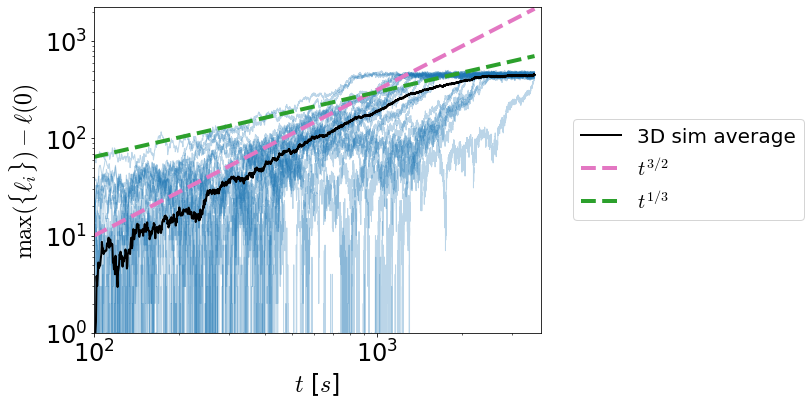

In [ ]:

fig, axarr = plt.subplots(1,1, figsize=(8,6), sharey=True, sharex=True)
plot_params = {"linewidth": 1, "markersize": .5, "marker":'', "alpha":0.3, "linestyle":'-'}

cluster_size_list = []
largest_time_arr = []
with h5py.File("Figure4/fig4_cluster_data.h5", 'r') as h5_graph:
    for name, d_set in h5_graph['dissolve'].items():
        try:
            clust_arr = d_set[:,1][::-1]
            condition = clust_arr > 40

            time_arr = d_set[condition,0][::-1]
            clust_arr = clust_arr[condition]
            if min(clust_arr) > 100: # Look for clusters that have not dissolved
                last_time_step = max(time_arr)
                if len(largest_time_arr) < len(time_arr):
                    print(len(time_arr))
                    largest_time_arr = time_arr
                # _ = axarr.plot(time_arr-last_time_step , clust_arr, color='tab:blue', **plot_params)
                # _ = axarr.plot(time_arr[200:], clust_arr[200:]-clust_arr[200], color='tab:blue', **plot_params)
                _ = axarr.plot(time_arr, clust_arr-clust_arr[0], color='tab:blue', **plot_params)
                cluster_size_list += [clust_arr]
        except:
            print("Error")
            print(name)
            print(d_set[:,1])
            print(d_set[:,0])
            pass
            

mean_size_arr = mean_of_arrays(cluster_size_list)
last_time_step = max(largest_time_arr)
_ = axarr.plot(largest_time_arr, mean_size_arr-mean_size_arr[0], label="3D sim average", color='k')
_ = axarr.plot(largest_time_arr, .01*np.power(largest_time_arr, 3/2), label="$t^{3/2}$", color='tab:pink', linestyle='--', linewidth=4)
_ = axarr.plot(largest_time_arr, 3*np.power(largest_time_arr, 2/3), label="$t^{2/3}$", color='tab:green', linestyle='--', linewidth=4)
# _ = axarr.annotate("$t^{3/2}$", (1e3, 1e3), color='tab:pink')
# _ = axarr.annotate("$t^{2/3}$", (2e2, 2e2), color='tab:green')

_ = axarr.set_xlim(1e2)
_ = axarr.set_ylim(1)

_ = axarr.legend(loc='center left', bbox_to_anchor=(1.05, .5))



_ = axarr.set_ylabel('$\max(\{\ell_i\})-\ell(0)$ ' )
_ = axarr.set_xlabel('$t$ [$s$]')
_ = axarr.set_xscale('log')
_ = axarr.set_yscale('log')



7201


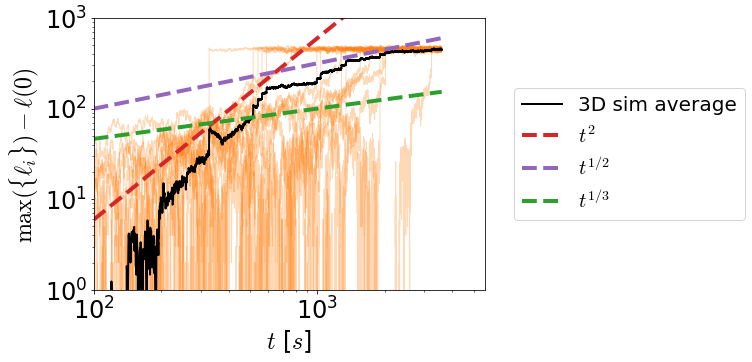

In [10]:

fig, axarr = plt.subplots(1,1, figsize=(7,5), sharey=True, sharex=True)
plot_params = {"linewidth": 1, "markersize": .5, "marker":'', "alpha":0.3, "linestyle":'-'}

cluster_size_list = []
largest_time_arr = []
with h5py.File("Figure4/fig4_cluster_data.h5", 'r') as h5_graph:
    for name, d_set in h5_graph['merge'].items():
        try:
            clust_arr = d_set[:,1][::-1]
            condition = clust_arr > 40

            time_arr = d_set[condition,0][::-1]
            clust_arr = clust_arr[condition]
            if max(clust_arr) > 600: # Look for clusters that ar merged aftwards
                last_time_step = max(time_arr)
                if len(largest_time_arr) < len(time_arr):
                    print(len(time_arr))
                    largest_time_arr = time_arr
                # _ = axarr.plot(time_arr-last_time_step , clust_arr, color='tab:blue', **plot_params)
                _ = axarr.plot(time_arr, clust_arr-clust_arr[0], color='tab:orange', **plot_params)
                cluster_size_list += [clust_arr]
        except:
            print("Error")
            print(name)
            print(d_set[:,1])
            print(d_set[:,0])
            pass
            

mean_size_arr = mean_of_arrays(cluster_size_list)
last_time_step = max(largest_time_arr)
_ = axarr.plot(largest_time_arr, mean_size_arr-mean_size_arr[0], label="3D sim average", color='k')
_ = axarr.plot(largest_time_arr, .0006*np.power(largest_time_arr, 2), label="$t^{2}$", color='tab:red', linestyle='--', linewidth=4)
_ = axarr.plot(largest_time_arr, 10*np.power(largest_time_arr, 1/2), label="$t^{1/2}$", color='tab:purple', linestyle='--', linewidth=4)
_ = axarr.plot(largest_time_arr, 10*np.power(largest_time_arr, 1/3), label="$t^{1/3}$", color='tab:green', linestyle='--', linewidth=4)
# _ = axarr.annotate("$t^{3/2}$", (1e3, 1e3), color='tab:orange')

_ = axarr.set_xscale('log')
_ = axarr.set_yscale('log')

_ = axarr.set_xlim(1e2)
_ = axarr.set_ylim(1,1000)


_ = axarr.set_ylabel('$\max(\{\ell_i\})-\ell(0)$ ' )
_ = axarr.set_xlabel('$t$ [$s$]')
_ = axarr.legend(loc='center left', bbox_to_anchor=(1.05, .5))




# Supplemental figures

(0.0, 1600.0)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


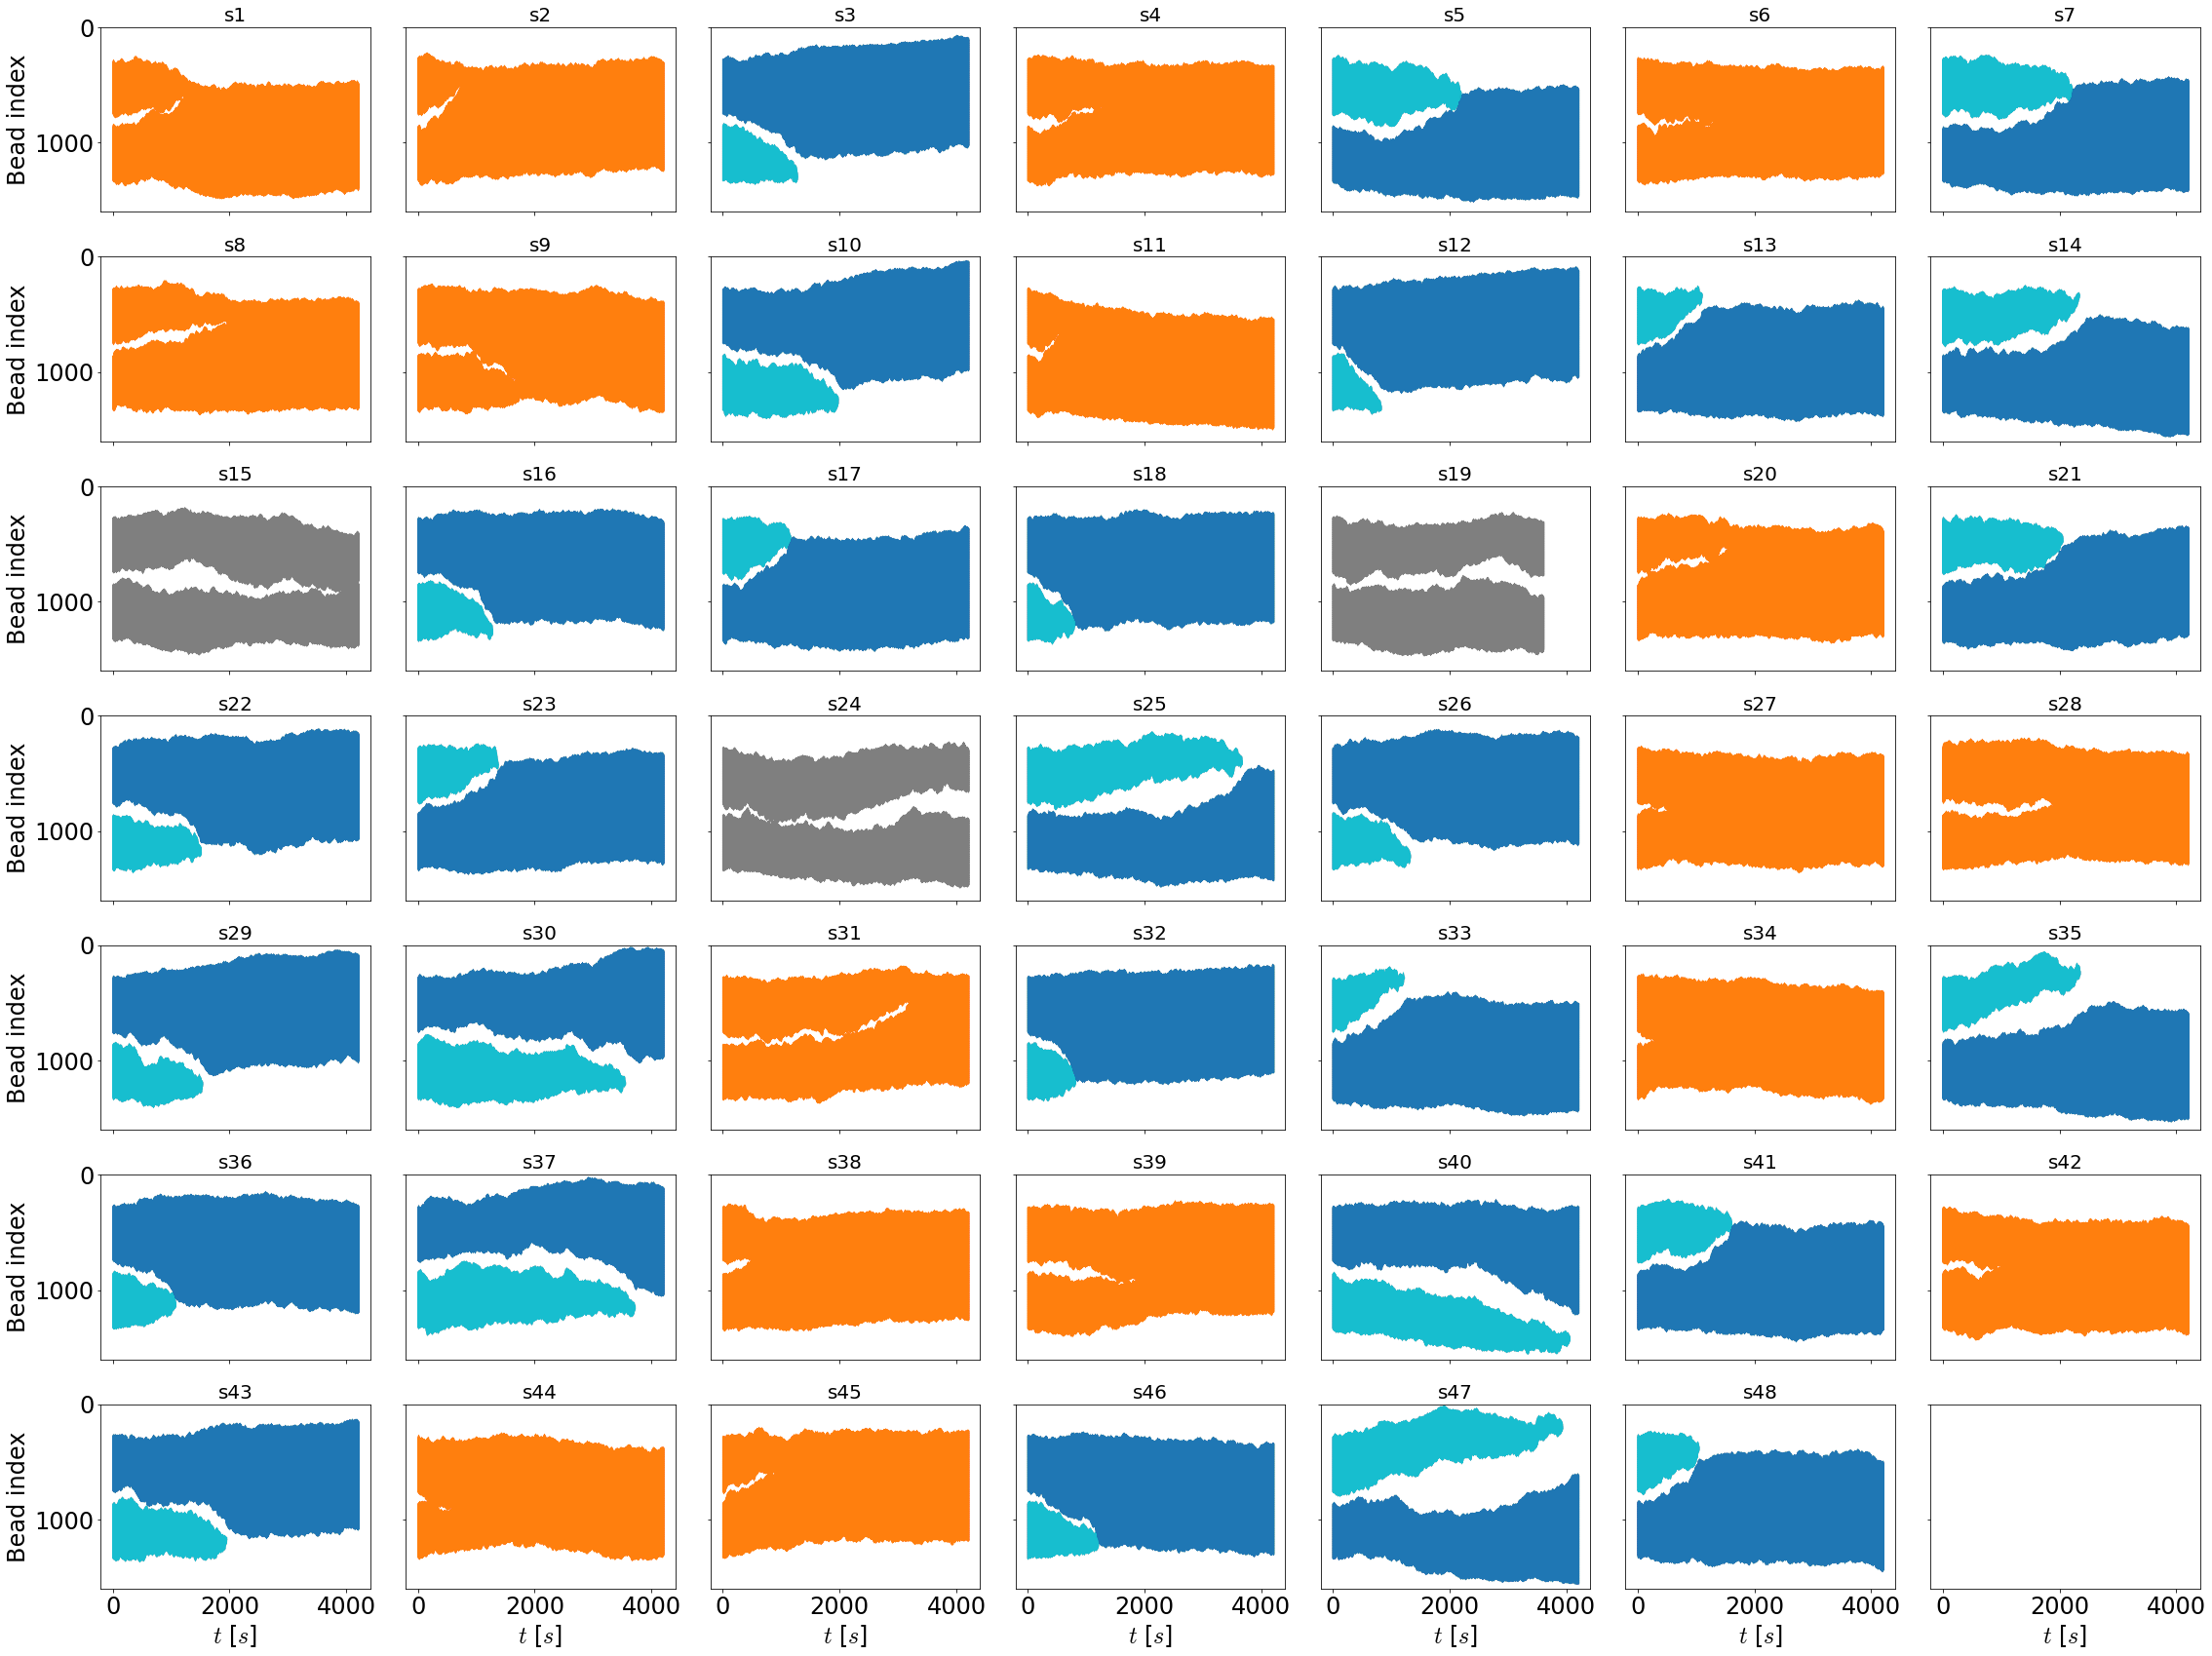

In [6]:
data_path = ceph_path / "DynCondPaper/24-04-15_aLc1_scan.48_line1600_Pin5um_2xKe30_ks100_2patch_sep100_equil"
h5_list = list(data_path.glob('simulations/*/analysis/cluster_analysis.h5'))

# sort h5_list by the parent parent directory name number that is s(number). Use regex to extract the number
h5_list = sorted(h5_list, key=lambda x: int(re.search(r'\d+', x.parent.parent.name).group()))

large_tree_length = 200

merge_events = 0
dissovle_events = 0
nothing_events = 0

graph_side_length = int(np.ceil(np.sqrt(len(h5_list))))

fig, axarr = plt.subplots(graph_side_length, graph_side_length, figsize=(32, 24), sharex=True, sharey=True)

n = 1
for i in range(graph_side_length):
    for j in range(graph_side_length):
        if i*graph_side_length + j >= len(h5_list):
            break
        try: 
            with h5py.File(h5_list[i*graph_side_length+j], 'r') as h5_data:
                cluster_grp = h5_data['clusters']
                time_arr = h5_data['time'][...]
                time_grp_list = sorted(cluster_grp.values(), key=lambda x: x.attrs['time'])
                clusters = []
                for tg in time_grp_list:
                    clusters += [[cla.Cluster(h5_data = c) for c in tg.values()]]

            # Cluster tree
            root_clusters = cla.find_descendants(clusters, thresh=cluster_similarity_threshold, nskip=nskip)

            trees = []

            tree_id_gen = aa.helpers.gen_id()
            for root in root_clusters:
                tree = cla.ClusterTree(next(tree_id_gen))
                tree.add_recursive(root)
                trees += [tree]

            # Filter trees for large trees only
            trees = [tree for tree in trees if len(tree.clusters) > large_tree_length]
            # Sort by tree size and take the top 2 
            trees = sorted(trees, key=lambda x: len(x.clusters), reverse=True)[:2]

            colors = ['tab:orange'] if len(trees) == 1 else [ 'tab:blue', 'tab:cyan' ]
            if len(colors) == 2 and trees[0].clusters[0].time == trees[1].clusters[0].time:
                colors = ['tab:gray', 'tab:gray']
                

            # Graph all clusters
            for tree, color in zip(trees, colors):
                for clust in tree.clusters:
                    _ = axarr[i,j].plot([clust.time]*len(clust.part_ids), clust.part_ids, color = color, markersize= .1, marker='.', linestyle='None')
            _ = axarr[i,j].set_title(h5_list[i*graph_side_length + j].parent.parent.name)
        except:
            raise

# axarr[0,0].set_xlim(0, 700)
axarr[0,0].set_ylim(0, 1600)
axarr[0,0].invert_yaxis()
for ax in axarr[:,0]:
    _ = ax.set_ylabel('Bead index')
for ax in axarr[-1,:]:
    _ = ax.set_xlabel('$t$ [$s$]')
fig.tight_layout()


fig.savefig("Figure7/fig7_supp_contact_kymos.png", dpi=300, bbox_inches="tight")
fig.savefig("/mnt/home/alamson/papers/dyn_cond_paper/images/fig7_supp_contact_kymo.png", dpi=300, bbox_inches="tight")


Takes about 20 minutes to run analysis

# Collect data

In [14]:
data_path = ceph_path / "DynCondPaper/24-04-15_aLc1_scan.48_line1600_Pin5um_2xKe30_ks100_2patch_sep100_equil"
h5_list = list(data_path.glob('simulations/*/analysis/cluster_analysis.h5'))

print(len(h5_list))

large_tree_length = 240

merge_times = []
dissolve_times = [] 
nothing_events = 0

tableau10_colors = iter(cycle(plt.cm.tab10.colors))

n = 0
with h5py.File("Figure7/fig7_cluster_data.h5", 'w') as h5_graph:
    merge_grp = h5_graph.create_group(f'merge')
    dissolve_grp = h5_graph.create_group(f'dissolve') 
    nothing_grp = h5_graph.create_group(f'nothing') 
    for h5_file in h5_list:
        n += 1
        try:
            sd_num = h5_file.parent.parent.name
            print(sd_num)
            with h5py.File(h5_file, 'r') as h5_data:
                cluster_grp = h5_data['clusters']
                time_arr = h5_data['time'][...]
                last_time = time_arr[-1]
                time_grp_list = sorted(cluster_grp.values(), key=lambda x: x.attrs['time'])
                clusters = []
                for tg in time_grp_list:
                    clusters += [[cla.Cluster(h5_data = c) for c in tg.values()]]
                    

            # Cluster tree
            root_clusters = cla.find_descendants(clusters, thresh=cluster_similarity_threshold, nskip=nskip)

            # The largest clusters at the start of the sim
            start_clusters = sorted(clusters[0], key=lambda x: len(x.part_ids), reverse=True)

            root0 = start_clusters[0].get_root()
            root1 = start_clusters[1].get_root()

            # If the two largest beginning clusters have the same root id at the end,
            # then this is a merging event

            if root0.id == root1.id:
                # Make the tree for these
                merge_tree = cla.ClusterTree(0) 
                merge_tree.add_recursive(root0)
                # Branch root with the largest mass history
                branch_root = sorted(merge_tree.get_branch_roots(), key=lambda x: x.mass_hist, reverse=True)[1]
                merge_times += [branch_root.time]
                print(f"{n} Merge event at time {branch_root.time}")

                l_branch = root0.get_largest_branch()
                data_arr = np.zeros((len(l_branch),3))
                for k, clust in enumerate(l_branch):
                    data_arr[k,0] = clust.time
                    data_arr[k,1] = len(clust.part_ids)
                    data_arr[k,2] = .5* (max(clust.part_ids) + min(clust.part_ids))
                merge_0_dset = merge_grp.create_dataset(f'{sd_num}_0', data=data_arr)
                
                sl_branch = branch_root.get_largest_branch()
                data_arr = np.zeros((len(sl_branch),3))
                for k, clust in enumerate(sl_branch):
                    data_arr[k,0] = clust.time
                    data_arr[k,1] = len(clust.part_ids)
                    data_arr[k,2] = .5* (max(clust.part_ids) + min(clust.part_ids))
                merge_1_dset = merge_grp.create_dataset(f'{sd_num}_1', data=data_arr)

                continue

            min_root_time = min(root0.time, root1.time)
            if min_root_time < last_time:
                dissolve_times += [min_root_time]
                print(f"{n} Dissolve event at time {min_root_time}")
                dissolve_tree = cla.ClusterTree(0) 
                dissolve_tree.add_recursive(root0)

                l_branch = root0.get_largest_branch()

                data_arr = np.zeros((len(l_branch),3))
                for k, clust in enumerate(l_branch):
                    data_arr[k,0] = clust.time
                    data_arr[k,1] = len(clust.part_ids)
                    data_arr[k,2] = .5* (max(clust.part_ids) + min(clust.part_ids))
                dissolve_0_dset = dissolve_grp.create_dataset(f'{sd_num}_0', data=data_arr)

                dissolve_tree_1 = cla.ClusterTree(1) 
                dissolve_tree_1.add_recursive(root1)
                l_branch = root1.get_largest_branch()
                data_arr = np.zeros((len(l_branch),3))
                for k, clust in enumerate(l_branch):
                    data_arr[k,0] = clust.time
                    data_arr[k,1] = len(clust.part_ids)
                    data_arr[k,2] = .5* (max(clust.part_ids) + min(clust.part_ids))
                dissolve_1_dset = dissolve_grp.create_dataset(f'{sd_num}_1', data=data_arr)

                continue
            
            nothing_events += 1
            print(f"{n} Nothing event")

            l_branch = root0.get_largest_branch()
            data_arr = np.zeros((len(l_branch),3))
            for k, clust in enumerate(l_branch):
                data_arr[k,0] = clust.time
                data_arr[k,1] = len(clust.part_ids)
                data_arr[k,2] = .5* (max(clust.part_ids) + min(clust.part_ids))
            dissolve_0_dset = nothing_grp.create_dataset(f'{sd_num}_0', data=data_arr)

            l_branch = root1.get_largest_branch()
            data_arr = np.zeros((len(l_branch),3))
            for k, clust in enumerate(l_branch):
                data_arr[k,0] = clust.time
                data_arr[k,1] = len(clust.part_ids)
                data_arr[k,2] = .5* (max(clust.part_ids) + min(clust.part_ids))
            dissolve_1_dset = nothing_grp.create_dataset(f'{sd_num}_1', data=data_arr)
        

        except:
            raise

    merge_grp.attrs['merge_times'] = merge_times
    dissolve_grp.attrs['dissolve_times'] = dissolve_times
    nothing_grp.attrs['nothing_events'] = nothing_events

48
s20
1 Merge event at time 1554.5
s11
2 Merge event at time 541.0
s18
3 Dissolve event at time 792.0
s12
4 Dissolve event at time 816.0
s31
5 Merge event at time 3242.5
s25
6 Dissolve event at time 3660.5
s5
7 Dissolve event at time 2183.5
s9
8 Merge event at time 1727.5
s35
9 Dissolve event at time 2338.5
s39
10 Merge event at time 2015.0
s29
11 Dissolve event at time 1521.5
s32
12 Dissolve event at time 800.5
s19
13 Nothing event
s47
14 Dissolve event at time 3921.0
s15
15 Nothing event
s41
16 Dissolve event at time 1593.0
s43
17 Dissolve event at time 1935.5
s17
18 Dissolve event at time 1145.0
s8
19 Merge event at time 1966.0
s13
20 Dissolve event at time 1090.0
s34
21 Merge event at time 327.0
s7
22 Dissolve event at time 2201.5
s1
23 Merge event at time 1272.5
s36
24 Dissolve event at time 1061.0
s27
25 Merge event at time 515.0
s38
26 Merge event at time 564.5
s4
27 Merge event at time 1281.0
s26
28 Dissolve event at time 1312.5
s10
29 Dissolve event at time 1965.0
s42
30 Merg

In [5]:
data_path = ceph_path / "DynCondPaper/24-02-30_aLc1_scan.32_line1600_Pin5um_2xKe30_ks100_2patch_equil"
h5_list = list(data_path.glob('simulations/*/analysis/cluster_analysis.h5'))

print(len(h5_list))

large_tree_length = 240

merge_times = []
dissolve_times = [] 
nothing_events = 0

tableau10_colors = iter(cycle(plt.cm.tab10.colors))

n = 0
with h5py.File("Figure7/fig7_cluster_data_sep400.h5", 'w') as h5_graph:
    merge_grp = h5_graph.create_group(f'merge')
    dissolve_grp = h5_graph.create_group(f'dissolve') 
    nothing_grp = h5_graph.create_group(f'nothing') 
    for h5_file in h5_list:
        n += 1
        try:
            sd_num = h5_file.parent.parent.name
            print(sd_num)
            with h5py.File(h5_file, 'r') as h5_data:
                cluster_grp = h5_data['clusters']
                time_arr = h5_data['time'][...]
                last_time = time_arr[-1]
                time_grp_list = sorted(cluster_grp.values(), key=lambda x: x.attrs['time'])
                clusters = []
                for tg in time_grp_list:
                    clusters += [[cla.Cluster(h5_data = c) for c in tg.values()]]
                    

            # Cluster tree
            root_clusters = cla.find_descendants(clusters, thresh=cluster_similarity_threshold, nskip=nskip)

            # The largest clusters at the start of the sim
            start_clusters = sorted(clusters[0], key=lambda x: len(x.part_ids), reverse=True)

            root0 = start_clusters[0].get_root()
            root1 = start_clusters[1].get_root()

            # If the two largest beginning clusters have the same root id at the end,
            # then this is a merging event

            if root0.id == root1.id:
                # Make the tree for these
                merge_tree = cla.ClusterTree(0) 
                merge_tree.add_recursive(root0)
                # Branch root with the largest mass history
                branch_root = sorted(merge_tree.get_branch_roots(), key=lambda x: x.mass_hist, reverse=True)[1]
                merge_times += [branch_root.time]
                print(f"{n} Merge event at time {branch_root.time}")

                l_branch = root0.get_largest_branch()
                data_arr = np.zeros((len(l_branch),3))
                for k, clust in enumerate(l_branch):
                    data_arr[k,0] = clust.time
                    data_arr[k,1] = len(clust.part_ids)
                    data_arr[k,2] = .5* (max(clust.part_ids) + min(clust.part_ids))
                merge_0_dset = merge_grp.create_dataset(f'{sd_num}_0', data=data_arr)
                
                sl_branch = branch_root.get_largest_branch()
                data_arr = np.zeros((len(sl_branch),3))
                for k, clust in enumerate(sl_branch):
                    data_arr[k,0] = clust.time
                    data_arr[k,1] = len(clust.part_ids)
                    data_arr[k,2] = .5* (max(clust.part_ids) + min(clust.part_ids))
                merge_1_dset = merge_grp.create_dataset(f'{sd_num}_1', data=data_arr)

                continue

            min_root_time = min(root0.time, root1.time)
            if min_root_time < last_time:
                dissolve_times += [min_root_time]
                print(f"{n} Dissolve event at time {min_root_time}")
                dissolve_tree = cla.ClusterTree(0) 
                dissolve_tree.add_recursive(root0)

                l_branch = root0.get_largest_branch()

                data_arr = np.zeros((len(l_branch),3))
                for k, clust in enumerate(l_branch):
                    data_arr[k,0] = clust.time
                    data_arr[k,1] = len(clust.part_ids)
                    data_arr[k,2] = .5* (max(clust.part_ids) + min(clust.part_ids))
                dissolve_0_dset = dissolve_grp.create_dataset(f'{sd_num}_0', data=data_arr)

                dissolve_tree_1 = cla.ClusterTree(1) 
                dissolve_tree_1.add_recursive(root1)
                l_branch = root1.get_largest_branch()
                data_arr = np.zeros((len(l_branch),3))
                for k, clust in enumerate(l_branch):
                    data_arr[k,0] = clust.time
                    data_arr[k,1] = len(clust.part_ids)
                    data_arr[k,2] = .5* (max(clust.part_ids) + min(clust.part_ids))
                dissolve_1_dset = dissolve_grp.create_dataset(f'{sd_num}_1', data=data_arr)

                continue
            
            nothing_events += 1
            print(f"{n} Nothing event")

            l_branch = root0.get_largest_branch()
            data_arr = np.zeros((len(l_branch),3))
            for k, clust in enumerate(l_branch):
                data_arr[k,0] = clust.time
                data_arr[k,1] = len(clust.part_ids)
                data_arr[k,2] = .5* (max(clust.part_ids) + min(clust.part_ids))
            dissolve_0_dset = nothing_grp.create_dataset(f'{sd_num}_0', data=data_arr)

            l_branch = root1.get_largest_branch()
            data_arr = np.zeros((len(l_branch),3))
            for k, clust in enumerate(l_branch):
                data_arr[k,0] = clust.time
                data_arr[k,1] = len(clust.part_ids)
                data_arr[k,2] = .5* (max(clust.part_ids) + min(clust.part_ids))
            dissolve_1_dset = nothing_grp.create_dataset(f'{sd_num}_1', data=data_arr)
        
            merge_grp.attrs['merge_times'] = merge_times
            dissolve_grp.attrs['dissolve_times'] = dissolve_times
            nothing_grp.attrs['nothing_events'] = nothing_events

        except:
            raise

32
s20
1 Nothing event
s11
2 Nothing event
s18
3 Nothing event
s12
4 Nothing event
s31
5 Nothing event
s25
6 Nothing event
s5
7 Nothing event
s9
8 Nothing event
s29
9 Nothing event
s32
10 Nothing event
s19
11 Nothing event
s15
12 Nothing event
s17
13 Nothing event
s8
14 Nothing event
s13
15 Nothing event
s7
16 Nothing event
s1
17 Nothing event
s27
18 Nothing event
s4
19 Nothing event
s26
20 Nothing event
s10
21 Nothing event
s16
22 Nothing event
s23
23 Nothing event
s28
24 Nothing event
s22
25 Nothing event
s21
26 Nothing event
s14
27 Nothing event
s3
28 Nothing event
s24
29 Nothing event
s2
30 Nothing event
s6
31 Nothing event
s30
32 Nothing event


In [39]:
data_path = ceph_path / "DynCondPaper/24-02-30_aLc1_scan.32_line1600_Pin5um_2xKe30_ks100_kod300_2patch_equil"
h5_list = list(data_path.glob('simulations/*/analysis/cluster_analysis.h5'))

print(len(h5_list))

large_tree_length = 240

merge_times = []
dissolve_times = [] 
nothing_events = 0

tableau10_colors = iter(cycle(plt.cm.tab10.colors))

n = 0
with h5py.File("Figure7/fig7_cluster_data_sep400_kod300.h5", 'w') as h5_graph:
    merge_grp = h5_graph.create_group(f'merge')
    dissolve_grp = h5_graph.create_group(f'dissolve') 
    nothing_grp = h5_graph.create_group(f'nothing') 
    for h5_file in h5_list:
        n += 1
        try:
            sd_num = h5_file.parent.parent.name
            print(sd_num)
            with h5py.File(h5_file, 'r') as h5_data:
                cluster_grp = h5_data['clusters']
                time_arr = h5_data['time'][...]
                last_time = time_arr[-1]
                time_grp_list = sorted(cluster_grp.values(), key=lambda x: x.attrs['time'])
                clusters = []
                for tg in time_grp_list:
                    clusters += [[cla.Cluster(h5_data = c) for c in tg.values()]]
                    

            # Cluster tree
            root_clusters = cla.find_descendants(clusters, thresh=cluster_similarity_threshold, nskip=nskip)

            # The largest clusters at the start of the sim
            start_clusters = sorted(clusters[0], key=lambda x: len(x.part_ids), reverse=True)

            root0 = start_clusters[0].get_root()
            root1 = start_clusters[1].get_root()

            # If the two largest beginning clusters have the same root id at the end,
            # then this is a merging event

            if root0.id == root1.id:
                # Make the tree for these
                merge_tree = cla.ClusterTree(0) 
                merge_tree.add_recursive(root0)
                # Branch root with the largest mass history
                branch_root = sorted(merge_tree.get_branch_roots(), key=lambda x: x.mass_hist, reverse=True)[1]
                merge_times += [branch_root.time]
                print(f"{n} Merge event at time {branch_root.time}")

                l_branch = root0.get_largest_branch()
                data_arr = np.zeros((len(l_branch),3))
                for k, clust in enumerate(l_branch):
                    data_arr[k,0] = clust.time
                    data_arr[k,1] = len(clust.part_ids)
                    data_arr[k,2] = .5* (max(clust.part_ids) + min(clust.part_ids))
                merge_0_dset = merge_grp.create_dataset(f'{sd_num}_0', data=data_arr)
                
                sl_branch = branch_root.get_largest_branch()
                data_arr = np.zeros((len(sl_branch),3))
                for k, clust in enumerate(sl_branch):
                    data_arr[k,0] = clust.time
                    data_arr[k,1] = len(clust.part_ids)
                    data_arr[k,2] = .5* (max(clust.part_ids) + min(clust.part_ids))
                merge_1_dset = merge_grp.create_dataset(f'{sd_num}_1', data=data_arr)

                continue

            min_root_time = min(root0.time, root1.time)
            if min_root_time < last_time:
                dissolve_times += [min_root_time]
                print(f"{n} Dissolve event at time {min_root_time}")
                dissolve_tree = cla.ClusterTree(0) 
                dissolve_tree.add_recursive(root0)

                l_branch = root0.get_largest_branch()

                data_arr = np.zeros((len(l_branch),3))
                for k, clust in enumerate(l_branch):
                    data_arr[k,0] = clust.time
                    data_arr[k,1] = len(clust.part_ids)
                    data_arr[k,2] = .5* (max(clust.part_ids) + min(clust.part_ids))
                dissolve_0_dset = dissolve_grp.create_dataset(f'{sd_num}_0', data=data_arr)

                dissolve_tree_1 = cla.ClusterTree(1) 
                dissolve_tree_1.add_recursive(root1)
                l_branch = root1.get_largest_branch()
                data_arr = np.zeros((len(l_branch),3))
                for k, clust in enumerate(l_branch):
                    data_arr[k,0] = clust.time
                    data_arr[k,1] = len(clust.part_ids)
                    data_arr[k,2] = .5* (max(clust.part_ids) + min(clust.part_ids))
                dissolve_1_dset = dissolve_grp.create_dataset(f'{sd_num}_1', data=data_arr)

                continue
            
            nothing_events += 1
            print(f"{n} Nothing event")

            l_branch = root0.get_largest_branch()
            data_arr = np.zeros((len(l_branch),3))
            for k, clust in enumerate(l_branch):
                data_arr[k,0] = clust.time
                data_arr[k,1] = len(clust.part_ids)
                data_arr[k,2] = .5* (max(clust.part_ids) + min(clust.part_ids))
            dissolve_0_dset = nothing_grp.create_dataset(f'{sd_num}_0', data=data_arr)

            l_branch = root1.get_largest_branch()
            data_arr = np.zeros((len(l_branch),3))
            for k, clust in enumerate(l_branch):
                data_arr[k,0] = clust.time
                data_arr[k,1] = len(clust.part_ids)
                data_arr[k,2] = .5* (max(clust.part_ids) + min(clust.part_ids))
            dissolve_1_dset = nothing_grp.create_dataset(f'{sd_num}_1', data=data_arr)
        
            merge_grp.attrs['merge_times'] = merge_times
            dissolve_grp.attrs['dissolve_times'] = dissolve_times
            nothing_grp.attrs['nothing_events'] = nothing_events

        except:
            raise

32
s20
1 Nothing event
s11
2 Nothing event
s18
3 Nothing event
s12
4 Nothing event
s31
5 Nothing event
s25
6 Dissolve event at time 1057.5
s5
7 Nothing event
s9
8 Nothing event
s29
9 Nothing event
s32
10 Nothing event
s19
11 Nothing event
s15
12 Nothing event
s17
13 Nothing event
s8
14 Nothing event
s13
15 Nothing event
s7
16 Nothing event
s1
17 Nothing event
s27
18 Nothing event
s4
19 Nothing event
s26
20 Nothing event
s10
21 Nothing event
s16
22 Nothing event
s23
23 Nothing event
s28
24 Nothing event
s22
25 Nothing event
s21
26 Nothing event
s14
27 Dissolve event at time 1126.5
s3
28 Nothing event
s24
29 Nothing event
s2
30 Nothing event
s6
31 Nothing event
s30
32 Nothing event


Takes about 20 minutes to analyze.

In [32]:
import numpy as np

# Example arrays
array1 = np.array([1, 2, 2, 3, 4, 4, 4, 5])
array2 = np.array([10, 20, 30, 40, 50, 60, 70, 80])

# Identify unique values and their indices
unique_values, indices = np.unique(array1, return_inverse=True)
print('indices:', indices)

# Initialize new arrays
new_array = np.zeros(len(unique_values))

# Iterate over unique values
for i, new_ind in enumerate(indices):
    new_array[new_ind] += array2[i]


print("Unique vals:", unique_values)
print("new array", new_array)

indices: [0 1 1 2 3 3 3 4]
Unique vals: [1 2 3 4 5]
new array [ 10.  50.  40. 180.  80.]
